# Convert tf.keras model to ONNX

This tutorial shows how to convert trained tf.keras model to ONNX from the saved model file or the source code directly.

## Install ONNX dependencies
- `tf2onnx` provides a tool to convert TensorFlow model to ONNX
- `onnxruntime` is used to run inference on a saved ONNX model.

In [ ]:
!pip install -U tf2onnx
!pip install onnxruntime

## Train a sample model

### Imports

In [ ]:
import tf2onnx
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

### Get flowers dataset from TFDS

In [ ]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


### Visualize examples from training set

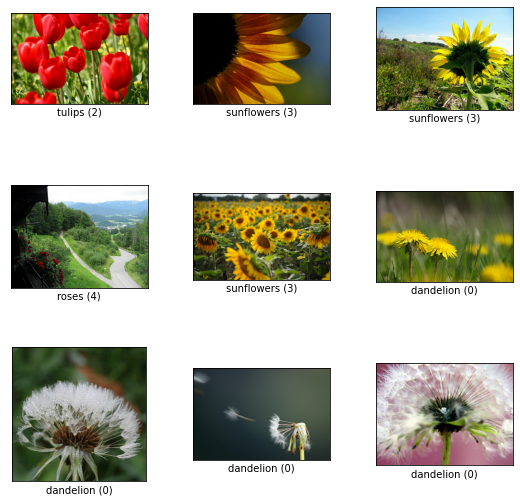

In [ ]:
_ = tfds.visualization.show_examples(training_set, dataset_info)

### Data preprocess

In [ ]:
IMAGE_RES = 224
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

In [ ]:
NUM_TRAINING_EXAMPLES = len(training_set)
BATCH_SIZE = 32

train_batches = training_set.map(format_image).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE, drop_remainder=True)

### Build a model 

In [ ]:
NUM_CLASSES = dataset_info.features['label'].num_classes

back_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3))
model = tf.keras.Sequential([
  back_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 5)                 501765    
                                                                 
Total params: 24,089,477
Trainable params: 24,036,357
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [ ]:
EPOCHS = 1

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


80/80 [==============================] - 96s 974ms/step - loss: 4.7417 - accuracy: 0.4551 - val_loss: 636306.3750 - val_accuracy: 0.1829


## Convert to ONNX

### Conversion

`opset` in `tf2onnx.convert.from_keras` is the ONNX Op version. You can find the full list which TF Ops are convertible to ONNX Ops [[here](https://github.com/onnx/tensorflow-onnx/blob/master/support_status.md)].

In [ ]:
import onnx

input_signature = [tf.TensorSpec([None, 224, 224, 3], tf.float32, name='x')]
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=15)
onnx.save(onnx_model, "my_model.onnx")

# model.save('my_model')
# !python -m tf2onnx.convert --saved-model my_model --output my_model.onnx

### Test converted ONNX model with dummy data

If you want to inference with GPU, then you can do so by setting `providers=["CUDAExecutionProvider"]` in `ort.InferenceSession`.

The first parameter in `sess.run` is set to `None`, and that means all the outputs of the model will be retrieved. 

In [ ]:
import onnxruntime as ort
import numpy as np

input1 = np.zeros((2, 224, 224, 3), np.float32)

sess = ort.InferenceSession("my_model.onnx") # providers=["CUDAExecutionProvider"])

results_ort = sess.run(None, {"x": input1})
print(results_ort)
print(np.argmax(results_ort, axis=2))

[array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)]
[[3 3]]
